# Bounding Box Regression
To construct a CNN architecture that can output bounding box coordinates: we can actually train the model to make better object detector predictions.


In [1]:
import tensorflow as tf
print(tf.__version__)
tf.config.list_physical_devices()

2.9.2


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from  tensorflow.keras.applications import VGG16

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input

from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

In [3]:
# main forlder: including images folder and csv file
BASE_PATH = "dataset"
# Concatenate any number of strings.
# The string whose method is called is inserted in between each given string.
# The result is returned as a new string.
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "airplanes.csv"])

In [4]:
# initialize three lists:
# data --> images in numpy array
# target --> output predictions(bounding box coordinates) 
# filenames of the individual images
data = []
targets = []
filenames = []

In [5]:
rows = open(ANNOTS_PATH).read().strip().split("\n")
# loop over the rows
for row in rows:
    # break the row into the filename and bounding box coordinates
    (filename, startX, startY, endX, endY) = row.split(",")

    # derive the path to the input image, load the image (in OpenCV
    # format), and grab its dimensions
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]

    # scale the bounding box coordinates relative to the spatial
    # dimensions of the input image
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h

    # load the image and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)

    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)

In [6]:
# convert the data and targets to NumPy arrays and float32
# Scaling the input pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

In [7]:
# Partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

In order to perform bounding box regression for object detection, all we need to do is adjust our network architecture:


At the head of the network, place a fully-connected layer with four neurons, corresponding to the top-left and bottom-right (x, y)-coordinates, respectively.

Given that four-neuron layer, implement a sigmoid activation function such that the outputs are returned in the range [0, 1].

Train the model using a loss function such as mean-squared error or mean-absolute error on training data that consists of:

(1) the input images 

(2) the bounding box of the object in the image.

1. Loading our airplane training data from disk (i.e., both class labels and bounding box coordinates)

2. Loading VGG16 from disk (pre-trained on ImageNet), removing the fully-connected classification layer head from the network, and inserting our bounding box regression layer head

3. Fine-tuning the bounding box regression layer head on our training data

In [8]:
# Load VGG16 with pre-trained ImageNet weights, ensuring the head FC layers are left off
# Chopping off the old fully-connected classification layer head --> last layer
print("[INFO] loading VGG16...")
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

[INFO] loading VGG16...
58889256/58889256 [==============================] - 3s 0us/step


In [9]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(32, activation = "relu"))
# output predictions(bounding box coordinates) --> 4 
# We normalized bounding boxed to (0,1), so sigmoid is the best activation function 
model.add(Dense(4, activation = "sigmoid"))


In [10]:
# If you set trainable = False on a model or on any layer that has sublayers 
# that all children layers become non-trainable as well
# False on a model or on any layer means freezing them, so as to avoid destroying 
# any of the information they contain during future training rounds
vgg.trainable = False

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 17,936,548
Trainable params: 3,221,860
Non

In [12]:
opt = Adam(learning_rate=1e-4)
model.compile(optimizer = opt, loss = "mse")

In [13]:
H = model.fit(
trainImages, trainTargets,
validation_data=(testImages, testTargets),
batch_size=32,
epochs=25,
verbose=1)

Epoch 1/25
23/23 [==============================] - 16s 244ms/step - loss: 0.0097 - val_loss: 0.0026
Epoch 2/25
23/23 [==============================] - 4s 167ms/step - loss: 0.0016 - val_loss: 7.4879e-04
Epoch 3/25
23/23 [==============================] - 4s 168ms/step - loss: 9.4066e-04 - val_loss: 5.9280e-04
Epoch 4/25
23/23 [==============================] - 4s 169ms/step - loss: 7.2620e-04 - val_loss: 5.7879e-04
Epoch 5/25
23/23 [==============================] - 4s 169ms/step - loss: 5.9431e-04 - val_loss: 5.2248e-04
Epoch 6/25
23/23 [==============================] - 4s 169ms/step - loss: 5.1211e-04 - val_loss: 5.0557e-04
Epoch 7/25
23/23 [==============================] - 4s 170ms/step - loss: 4.3294e-04 - val_loss: 5.4595e-04
Epoch 8/25
23/23 [==============================] - 4s 172ms/step - loss: 3.6999e-04 - val_loss: 4.9642e-04
Epoch 9/25
23/23 [==============================] - 4s 171ms/step - loss: 3.0639e-04 - val_loss: 5.0812e-04
Epoch 10/25
23/23 [====================

In [16]:
model.save("Localization.h5", save_format = "h5")

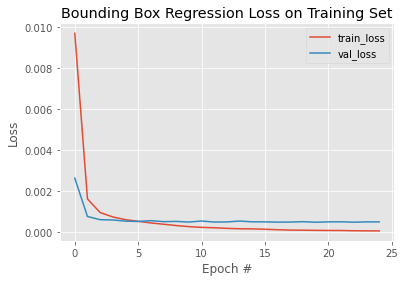

In [19]:
# plot the model training history
N = H.params['epochs']
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

In [20]:
H.history

{'loss': [0.009713246487081051,
  0.0016069860430434346,
  0.0009406630415469408,
  0.0007261961000040174,
  0.0005943106370978057,
  0.0005121092544868588,
  0.0004329399380367249,
  0.0003699917288031429,
  0.00030638850876130164,
  0.00025370673392899334,
  0.00021709708380512893,
  0.00019864442583639175,
  0.00016794400289654732,
  0.00014926193398423493,
  0.00014407966227736324,
  0.00012433961092028767,
  0.00010199003736488521,
  8.318238542415202e-05,
  7.84035655669868e-05,
  7.011117122601718e-05,
  6.544365169247612e-05,
  6.302620022324845e-05,
  5.11430662299972e-05,
  4.583050758810714e-05,
  4.3271407776046544e-05],
 'val_loss': [0.0026232432574033737,
  0.0007487928378395736,
  0.000592797645367682,
  0.0005787881673313677,
  0.0005224811611697078,
  0.0005055658402852714,
  0.0005459541571326554,
  0.0004964237450622022,
  0.0005081190611235797,
  0.0004774979897774756,
  0.0005276284064166248,
  0.00047716902918182313,
  0.00048304014489986,
  0.000525176408700645,


# Implementing bounding box predictor with Keras and TensorFlow

In [23]:
from tensorflow.keras.models import load_model

In [24]:
# load the trained bounding box regressor/model
print("[INFO] loading object detector...")
model = load_model('/content/Localization.h5')


[INFO] loading object detector...


In [28]:
def inference(imagePath):
    # Load the input image (in Keras format) -->
    # - Numpy Array
    # - float32
    # Scaling the pixel intensities to the range [0, 1]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    # Adding a batch dimension
    image = np.expand_dims(image, axis=0)

    # Make bounding box predictions on the input image
    preds = model.predict(image)[0]
    return preds
 

In [29]:
def draw_bbox(img, preds):
    image = np.copy(img)
    (startX, startY, endX, endY) = preds
    (h, w) = image.shape[:2]

    # scale the predicted bounding box coordinates based on the image
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)

    # draw the predicted bounding box on the image
    cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
    return image

1/1 [==============================] - 0s 17ms/step


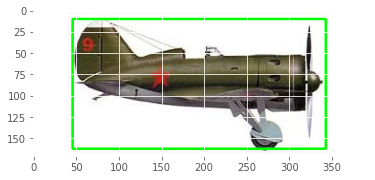

In [37]:
imagePath = './dataset/images/image_0100.jpg'
image = plt.imread(imagePath)
preds = inference(imagePath)
image_with_bbox = draw_bbox(image, preds)

# show the output image
plt.imshow(image_with_bbox)


Source:

https://www.pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/